## Flooded ice in the Weddell Sea

We're interested in looking at flooded ice in the Weddell sea for a number of reasons, one specific reason is that snow ice is derived from flooded ice processes. This snow ice is an indirect freshwater input in the global system. Here, we're just looking at the ice thickness from one track in the Weddell Sea.


In [41]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IS2view
import pprint
import scipy
import icepyx as ipx
import earthaccess
import h5py
from tqdm import tqdm
import shapely
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sliderule import sliderule, icesat2, earthdata
import ipyleaflet
import geopandas as gpd
from shapely.geometry import Point
from shapely import Polygon
import os
import seaborn as sns
import xarray as xr
import hvplot.xarray
import cartopy.crs as ccrs
%matplotlib inline

In [53]:
auth = earthaccess.login()
# attempt to use cloud streaming if in us-west-2
try:
    provider = "NSIDC_CPRD"
    asset = "nsidc-s3"
    fs = earthaccess.get_s3fs_session(provider=provider)
except (AttributeError, NameError) as exc:
    provider = "NSIDC_ECS"

    asset = "nsidc-https"

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/jovyan


Enter your Earthdata Login username:  julliancbw9
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/07/2023
Using user provided credentials for EDL


In [5]:
# spatial extent -54.15,-74.88,-35.14,-69.71

In [54]:
result = ipx.Query(
    product="ATL10",
    spatial_extent = [-54.15,-74.88,-35.14,-69.71],
    date_range = ['2020-03-01','2020-03-30'],
)

In [55]:
gran_id = result.avail_granules()
gran_id

{'Number of available granules': 52,
 'Average size of granules (MB)': 37.21873215528077,
 'Total size of all granules (MB)': 1935.3740720745996}

In [56]:
result = ipx.Query(
    product="ATL10",
    spatial_extent = [-54.15,-74.88,-35.14,-69.71],
    date_range = ['2020-03-01','2020-03-30'],
)
s3links = result.avail_granules(cloud=True)[0]  # returns a nested list, get first element
s3links

['s3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/01/ATL10-02_20200301043422_10000601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/01/ATL10-02_20200301170841_10080601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/02/ATL10-02_20200302040842_10150601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/02/ATL10-02_20200302181718_10240601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/03/ATL10-02_20200303051719_10310601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/03/ATL10-02_20200303175138_10390601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/04/ATL10-02_20200304045140_10460601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/04/ATL10-02_20200304172558_10540601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/05/ATL10-02_20200305042601_10610601_006_01.h5',
 's3://nsidc-cumulus-prod-pr

In [57]:
result = earthaccess.search_data(
    short_name = 'ATL10',
    version = '005',
    cloud_hosted = True,
    bounding_box = (-54.15,-74.88,-35.14,-69.71),
    temporal = ('2020-03-01','2020-03-30'),
    count = 100
)

Granules found: 51


In [58]:
files = earthaccess.open(result)
ds = xr.open_dataset(files[49],group='/gt3r/freeboard_beam_segment')

 Opening 51 granules, approx size: 1.91 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/51 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
[display(r) for r in result] #map plots

In [13]:
ds

<xarray.Dataset>
Dimensions:                        (delta_time: 134, ds_si_hist_bins: 161)
Coordinates:
  * delta_time                     (delta_time) datetime64[ns] 2020-03-29T04:...
  * ds_si_hist_bins                (ds_si_hist_bins) int32 1 2 3 ... 159 160 161
    latitude                       (delta_time) float64 ...
    longitude                      (delta_time) float64 ...
Data variables: (12/16)
    beam_fb_height                 (delta_time) float32 ...
    beam_fb_hist                   (delta_time, ds_si_hist_bins) int16 ...
    beam_fb_length                 (delta_time) float32 ...
    beam_fb_sigma                  (delta_time) float32 ...
    beam_lead_n                    (delta_time) int32 ...
    beam_lead_ndx                  (delta_time) int32 ...
    ...                             ...
    beam_refsurf_geoid_free2mean   (delta_time) float32 ...
    beam_refsurf_height            (delta_time) float32 ...
    beam_refsurf_interp_flag       (delta_time) int16 ...
    beam_refsurf_mss               (delta_time) float32 ...
    beam_refsurf_sigma             (delta_time) float32 ...
    fbswath_ndx                    (delta_time) int32 ...
Attributes:
    Description:  Contains freeboard estimate and associated height segment p...
    data_rate:    Data within this group are stored at the freeboard swath se...

## We chose a random entry and saw the date (Mar-29-2020). We'll show the region of interest in the Weddell Sea.

In [10]:
target_date = '2020-03-29' #'YYYY-MM-DD'

In [18]:
aoi_name = 'weddell' 

aoi_data = {
    'user_defined': {
        'target_date': target_date,
        'bbox_coords': [],
    },
    'weddell': {
        'target_date': '2022-03-029',
        'bbox_coords': [[[-40.48606548584821,-74.97534628136081],
                        [-37.056388101330086,-75.8319617325704],
                        [-33.892325601330086,-74.88246998123945],
                        [-37.583731851330086,-74.05907753555164],
                        [-40.48606548584821,-74.97534628136081]]]
    }
}

try:
    aoi_info = aoi_data[aoi_name]
    target_date = aoi_info['target_date']
    bbox_coords = aoi_info['bbox_coords']
    
except KeyError:
    raise RuntimeError("Invalid AOI name")

In [67]:
# function to store any bounds drawn by the user
def handle_draw(target, action, geo_json):
    if action == 'created':
        coords = geo_json['geometry']['coordinates'][0]
        bbox_coords.append(coords)

def reverse_coordinates(bbox_coords):
    reversed_coords = []
    
    for box in bbox_coords:
        reversed_box = []
        for point in box:
            reversed_box.append([point[1], point[0]])
        reversed_coords.append(reversed_box)
    
    return reversed_coords

# setting up the map
m = ipyleaflet.Map(basemap=ipyleaflet.basemaps.Esri.WorldImagery, 
        center=(0, 0), 
        zoom=3, 
        scroll_wheel_zoom=True)

# simplifying user options - can be used to enable polygons, line drawings, etc
dc = ipyleaflet.DrawControl(circlemarker={}, polyline={})

# defining bounding box/polygon properties
custom_shape_options = {
        "fillColor": "red",
        "color": "red",
        "fillOpacity": 0.5
    }

dc.rectangle = {"shapeOptions": custom_shape_options}
dc.polygon = {"shapeOptions": custom_shape_options}

# add pre-existing bounding box to map if it exists
if aoi_name == 'user_defined':
    bbox_coords = []
    print('Draw bounding box on map below...')

else:
    poly_gdf = gpd.GeoDataFrame(geometry=[Polygon(bbox_coords[0])],
                                crs="EPSG:3031")

    m.center=(poly_gdf.geometry[0].centroid.y, poly_gdf.geometry[0].centroid.x)
    m.zoom = 8

    poly_map = ipyleaflet.Polygon(
        locations=reverse_coordinates(bbox_coords),
        color="red",
        fill_color="red"
    )

    m.add_layer(poly_map);
    m.add_layer(x);
    
dc.on_draw(handle_draw)
m.add_control(dc)

m

Map(center=[-74.93934749607484, -37.23135886442547], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Using average values for sea ice thickness conversions from:
* Tilling, R.L., Ridout, A. and Shepherd, A. (2018) ‘Estimating Arctic sea ice thickness and volume using cryosat-2 Radar Altimeter Data’, Advances in Space Research, 62(6), pp. 1203–1225. doi:10.1016/j.asr.2017.10.051.
* Zhao, J. et al. (2019) ‘Observation and thermodynamic modeling of the influence of snow cover on landfast sea ice thickness in Prydz Bay, East Antarctica’, Cold Regions Science and Technology, 168, p. 102869. doi:10.1016/j.coldregions.2019.102869. 

In [59]:
lat = ds['latitude']
lon = ds['longitude']
fb = ds['beam_fb_height']
denw = 1023.9
dens = 324
densi = 916.7
depsnow = 0.5

Ice thickness assumption based equation

hi = ((fb*1023.9)+(depsnow*dens))/((denw-densi))

In [60]:
#Looping through all values to calculate ice thickness
for x in fb:
    hi = ((fb*1023.9)+(depsnow*dens))/((denw-densi))
print (hi)

<xarray.DataArray 'beam_fb_height' (delta_time: 134)>
array([      nan,       nan, 3.8723173, 3.6157324, 3.1030154, 3.3516283,
       3.2523215,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan, 1.7288975, 1.8959781, 2.1210823,
       2.1104016,       nan, 1.9919237, 2.1267016, 3.1781929, 2.885448 ,
       2.664938 , 3.2048972, 2.8398452, 3.9663863, 3.4659884, 2.6357305,
       3.6761487, 4.0299926, 3.6700246, 2.8774993, 2.5954428, 2.5393302,
       2.7660499, 2.6932137, 2.6932213, 2.8353922, 2.851151 , 3.1260512,
       2.9959972, 2.6453133, 2.66468  , 2.9061327, 5.6533318, 5.1617455,
       2.8210552, 3.5794194, 3.2635813, 2.8882883, 3.8046358,       nan,
             nan, 3.0630426, 2.9450004, 3.0135512, 2.7723863, 3.8653555,
       3.1428635, 3.2290425, 3.8469837, 4.096751 , 3.5842583, 2.881900

Text(0, 0.5, 'freeboard(m)')

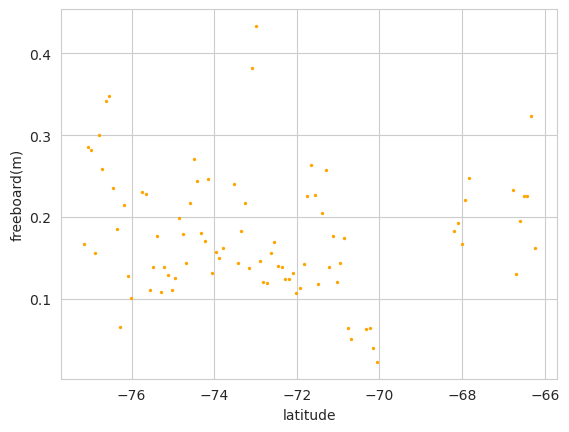

In [17]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size':10})
width = 0.2
edgecolor='black'
alpha=0.2
plt.scatter(lat,fb,s=2, c='orange')
plt.xlabel("latitude", fontsize=10)
plt.ylabel("freeboard(m)", fontsize=10)

Text(0, 0.5, 'ice thickness(m)')

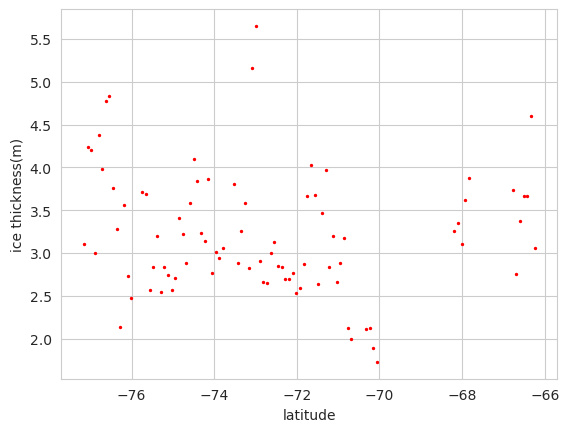

In [21]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size':10})
width = 0.2
edgecolor='black'
alpha=0.2
plt.scatter(lat,hi,s=2,c='red')
plt.xlabel("latitude", fontsize=10)
plt.ylabel("ice thickness(m)", fontsize=10)

We might want to look at the change in ice thickness over time for each trackline.
However, because of the mobility of ice in the Antartic Ocean, the ice floes detected along this track, is unlikely to recurr along track some time later. Even more so, the ice featurecan change through erosion, congelation etc. It would therefore be best to track specific floes over time. 

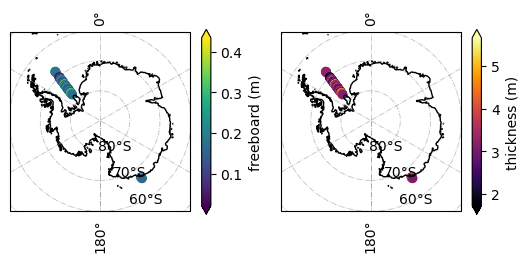

In [66]:
var0 = 'freeboard'
var1 = 'thickness'
projection = ccrs.SouthPolarStereo() 
crs = ccrs.PlateCarree()
ax1 = plt.subplot(121, projection=projection)
ax1.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax1.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
ax1.coastlines()
ax2 = plt.subplot(122, projection=projection)
ax2.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax2.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
ax2.coastlines()
s = ax1.scatter(ds["longitude"], ds["latitude"],c = ds["beam_fb_height"], cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(s,label=var0+' (m)', shrink=0.5, extend='both')
x = ax2.scatter(ds["longitude"], ds["latitude"], c = hi, cmap='inferno', transform=ccrs.PlateCarree())
plt.colorbar(x,label=var1+' (m)', shrink=0.5, extend='both')
plt.show()

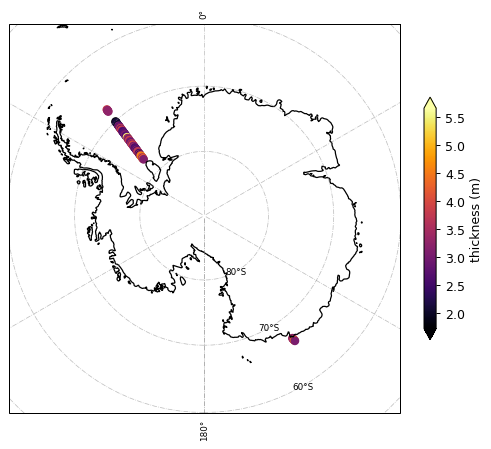

In [210]:
plt.figure(figsize=(7,7), dpi= 90)
projection = ccrs.SouthPolarStereo() 
crs = ccrs.PlateCarree()
ax = plt.axes(projection=projection, frameon=True)
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
gl.xlabel_style = {"size" : 7}
gl.ylabel_style = {"size" : 7}
ax.coastlines()

plt.scatter(ds["longitude"], ds["latitude"], c = hi, cmap='inferno', transform=ccrs.PlateCarree())
plt.colorbar(label=var1+' (m)', shrink=0.5, extend='both')
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())